# ch09 GAN(Generative Adversarial Network)

#### - UnSupervised(비지도학습 대표적)
#### - Generative : 생성모델(그럴듯한 가짜를 만들어 내는 모델)
#### - Adversarial : 2개의 모델(Discriminator, Constructor)을 적대적(Adversarial)으로 경쟁시키며 발전시킨다.위조지폐범과 경찰
#### - Network:Deep Learning

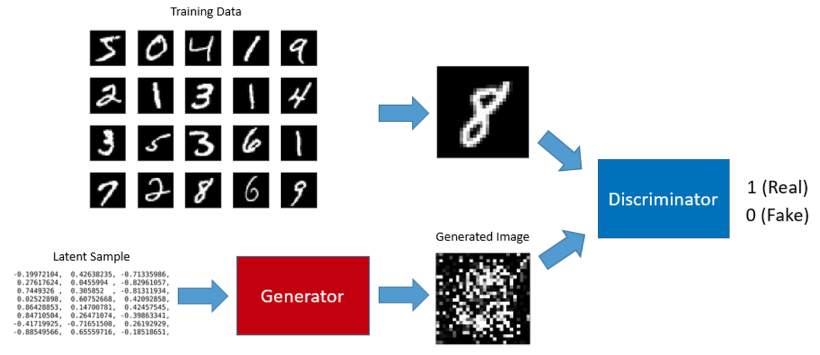

In [1]:
from IPython.display import Image
Image("../datasets/gan.png")

### 사용예
#### -사진을 고흐 풍 그림으로 다시 그리기
#### -선으로만 그려진 만화를 자동으로 채색
#### -모자이크 없애기

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
#Tensorflow에 기본적으로 내장되어 있는 데이터를 로드
from tensorflow.examples.tutorials.mnist import input_data
# 해당 폴더에 내용이 없으면,자동으로 데이터를 다운받기
mnist=input_data.read_data_sets('C:/JupyterSpace/datasets/mnist/data',one_hot=True)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting C:/JupyterSpace/datasets/mnist/data\train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting C:/JupyterSpace/datasets/mnist/data\train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting C:/JupyterSpace/datasets/mnist/data\t10k-images-idx3-ubyte.gz
Extracting C:/JupyterSpace/datasets/mnist/data\t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [4]:
learning_rate=0.0002 #최적화함수에서 사용할 학습률
batch_size=100 # 한번에  학습할 데이터
total_epoch=100#전체 데이터를 학습할 총 횟수
n_hidden=256 #hidden layer의 뉴런 갯수
n_input=28*28 #입력값의 크기
n_noise=128 # 가짜 이미지를 만들기 위한 생성기의 입력값

In [5]:
X=tf.placeholder(tf.float32,[None, n_input]) #진짜이미지
Z=tf.placeholder(tf.float32,[None, n_noise]) #noise(가짜이미지)

In [6]:
# 생성자(Constructor) 변수
G_W1=tf.Variable(tf.random_normal([n_noise, n_hidden],stddev=0.01))
G_b1=tf.Variable(tf.zeros([n_hidden]))
G_W2=tf.Variable(tf.random_normal([n_hidden, n_input],stddev=0.01))
G_b2=tf.Variable(tf.zeros([n_input]))

In [7]:
#구분자(Discriminator) 변수
D_W1=tf.Variable(tf.random_normal([n_input, n_hidden],stddev=0.01))
D_b1=tf.Variable(tf.zeros([n_hidden]))
D_W2=tf.Variable(tf.random_normal([n_hidden, 1],stddev=0.01)) # 진짜와 가까운 정도:1
D_b2=tf.Variable(tf.zeros([1]))

In [8]:
# Generator 신경망 구성
def generator(noize_z):
    hidden=tf.nn.relu(tf.matmul(noize_z, G_W1)+G_b1)
    output=tf.nn.sigmoid(tf.matmul(hidden, G_W2)+G_b2)
    return output

In [9]:
# 구분자(Discriminator) 신경망 구성
def discriminator(inputs):
    hidden=tf.nn.relu(tf.matmul(inputs, D_W1)+D_b1)
    output=tf.nn.sigmoid(tf.matmul(hidden, D_W2)+D_b2)
    return output

In [10]:
# noise
def get_noise(batch_size, n_noise):
    return np.random.normal(size=(batch_size, n_noise))

In [11]:
#noise를 랜덤한 가짜 이미지 
G=generator(Z)
# noise를 이용한 생성한 이미지가 진짜 이미지 인지 구분
D_gene=discriminator(G)
#진찌 이미지
D_real= discriminator(X)

In [12]:
#tf.log(D_real) : 진짜 이미지를 넣었을때 최대값
# tf.log(1-D_gene):가짜 이미지를 넣었을때 최대값
loss_D=tf.reduce_mean(tf.log(D_real)+tf.log(1-D_gene)) # D_gene: 최대화 목적
loss_G=tf.reduce_mean(tf.log(D_gene))

In [13]:
#2개 신경망 모델(discriminator, constructor)의 최적화 하기 위한 변수
D_var_list=[D_W1,D_b1, D_W2,D_b2]
G_var_list=[G_W1,G_b1, G_W2,G_b2]

In [14]:
#최적화
# -loss_D,  -loss_G:최적화에 음수 부여
train_D=tf.train.AdamOptimizer(learning_rate).minimize(-loss_D, var_list=D_var_list)
train_G=tf.train.AdamOptimizer(learning_rate).minimize(-loss_G, var_list=G_var_list)

In [15]:
init=tf.global_variables_initializer()
sess=tf.Session()
sess.run(init)

In [16]:
total_batch=int(mnist.train.num_examples/batch_size)
loss_val_D, loss_val_G = 0, 0

In [17]:
#epoch:학습 데이터를 전체를 한번 수행하는 것
for epoch in range(total_epoch):
    for i in range(total_batch):
        #지정한 크기만큼 학습데이터를 가져오기
        batch_xs, batch_ys =mnist.train.next_batch(batch_size)
        noise=get_noise(batch_size, n_noise)
        #2개 모델 각각 학습
        _, loss_val_D=sess.run([train_D,loss_D],feed_dict={X:batch_xs, Z:noise})
        _, loss_val_G=sess.run([train_G,loss_G],feed_dict={Z:noise})          
        
    print("Epoch:", '%04d' % epoch, 
          'D loss:{:4}'.format(loss_val_D),
          'G loss:{:4}'.format(loss_val_G))
   
    # 출력시 주기적으로 이미지 생성 저장   
    if epoch == 0 or (epoch+1) % 10 == 0:
        sample_size=10
        noise=get_noise(sample_size, n_noise)
        samples=sess.run(G, feed_dict={Z:noise})
        fig, ax=plt.subplots(1,sample_size, figsize=(sample_size,1))
          
        for i in range(sample_size):
            ax[i].set_axis_off()
            ax[i].imshow(np.reshape(samples[i],(28,28)))
        # 폴더이름 만들기(폴더명 작성)
        plt.savefig('samples1/{}.png'.format(str(epoch).zfill(3)), bbox_inches='tight')
        plt.close(fig)
          
          
print('최적화 완료')

Epoch: 0000 D loss:-0.37204304337501526 G loss:-2.2447474002838135
Epoch: 0001 D loss:-0.20517274737358093 G loss:-2.696087598800659
Epoch: 0002 D loss:-0.0961703285574913 G loss:-3.446622848510742
Epoch: 0003 D loss:-0.41634583473205566 G loss:-1.6570167541503906
Epoch: 0004 D loss:-0.27129268646240234 G loss:-2.065833806991577
Epoch: 0005 D loss:-0.26234883069992065 G loss:-2.582571029663086
Epoch: 0006 D loss:-0.18858693540096283 G loss:-2.932182550430298
Epoch: 0007 D loss:-0.22713525593280792 G loss:-3.051100730895996
Epoch: 0008 D loss:-0.4102157950401306 G loss:-2.6058661937713623
Epoch: 0009 D loss:-0.24485942721366882 G loss:-3.051271915435791
Epoch: 0010 D loss:-0.3464078903198242 G loss:-2.374627113342285
Epoch: 0011 D loss:-0.35805371403694153 G loss:-2.2648537158966064
Epoch: 0012 D loss:-0.15584953129291534 G loss:-3.3379409313201904
Epoch: 0013 D loss:-0.36096134781837463 G loss:-2.5928773880004883
Epoch: 0014 D loss:-0.4010899066925049 G loss:-2.302488327026367
Epoch: 0